To Do List:
1. Read all the files
2. Add meta data:
2.1.add date taken (consider all sources)
2.2.add ISO,Focal,Exposure,Apperture,Flash
2.3.add GPS info
2.4.create figures
3.Tag people
4.Create movies 
4.1.burst shots
4.2.time lapse
5.QC folder categories (taken in the same time and check if they are in he same folder)


In [6]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from IPython.display import Image
from IPython.core.display import HTML 
import time
import copy
import zipfile
import shutil
from ipywidgets import IntProgress
from time import gmtime, strftime
import matplotlib.patches as patches
import pip
import cv2 
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import folderstats
import tensorflow
from pip._internal import main
print(sys.executable)
print(sys.version)
print(strftime("%Y-%m-%d %H:%M:%S"))

C:\Users\mahdi\Anaconda3\python.exe
3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
2019-09-02 15:32:28


In [4]:
main([ 'install','opencv-contrib-python'])

  Using cached https://files.pythonhosted.org/packages/cc/ea/ea342b15c152fb862aeabb02402a0893199a59de821f3347a5fe9bfa2791/opencv_contrib_python-4.1.0.25-cp37-cp37m-win_amd64.whl


0

In [7]:
def get_date_taken(path):
    try:
        return Image.open(path)._getexif()[36867]
    except:
        return(pd.NaT)


class ImageMetaData(object):
    '''
    Extract the exif data from any image. Data includes GPS coordinates, 
    Focal Length, Manufacture, and more.
    '''
    exif_data = None
    image = None

    def __init__(self, img_path):
        self.image = Image.open(img_path)
        #print(self.image._getexif())
        self.get_exif_data()
        super(ImageMetaData, self).__init__()

    def get_exif_data(self):
        """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
        exif_data = {}
        info = self.image._getexif()
        if info:
            for tag, value in info.items():
                decoded = TAGS.get(tag, tag)
                if decoded == "GPSInfo":
                    gps_data = {}
                    for t in value:
                        sub_decoded = GPSTAGS.get(t, t)
                        gps_data[sub_decoded] = value[t]

                    exif_data[decoded] = gps_data
                else:
                    exif_data[decoded] = value
        self.exif_data = exif_data
        return exif_data

    def get_if_exist(self, data, key):
        if key in data:
            return data[key]
        return None

    def convert_to_degress(self, value):

        """Helper function to convert the GPS coordinates 
        stored in the EXIF to degress in float format"""
        d0 = value[0][0]
        d1 = value[0][1]
        d = float(d0) / float(d1)

        m0 = value[1][0]
        m1 = value[1][1]
        m = float(m0) / float(m1)

        s0 = value[2][0]
        s1 = value[2][1]
        s = float(s0) / float(s1)

        return d + (m / 60.0) + (s / 3600.0)

    def get_lat_lng(self):
        """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
        lat = None
        lng = None
        exif_data = self.get_exif_data()
        #print(exif_data)
        if "GPSInfo" in exif_data:      
            gps_info = exif_data["GPSInfo"]
            gps_latitude = self.get_if_exist(gps_info, "GPSLatitude")
            gps_latitude_ref = self.get_if_exist(gps_info, 'GPSLatitudeRef')
            gps_longitude = self.get_if_exist(gps_info, 'GPSLongitude')
            gps_longitude_ref = self.get_if_exist(gps_info, 'GPSLongitudeRef')
            if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
                lat = self.convert_to_degress(gps_latitude)
                if gps_latitude_ref != "N":                     
                    lat = 0 - lat
                lng = self.convert_to_degress(gps_longitude)
                if gps_longitude_ref != "E":
                    lng = 0 - lng
        return lat, lng
def GetMetaData(path):
    try:
        return(ImageMetaData(path).exif_data)
    except:
        return({})

[2019-09-02 15:33:10] reading files


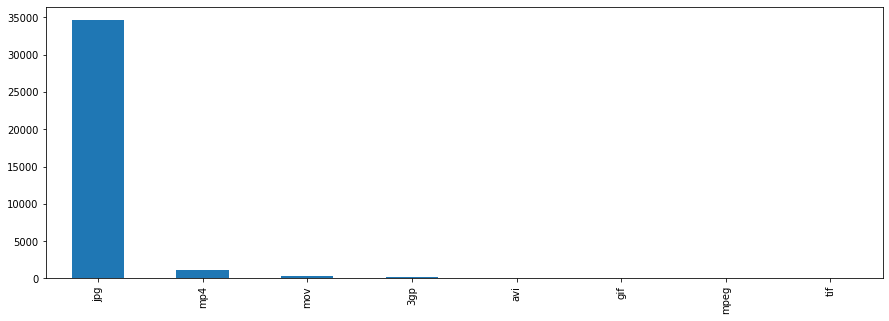

['path', 'name', 'extension', 'size']
[2019-09-02 15:33:28]  - (36359, 4)


In [8]:
print('[{}] reading files'.format(strftime("%Y-%m-%d %H:%M:%S")))
Photo_DF = folderstats.folderstats(r"C:\Users\mahdi\Pictures")
Photo_DF['extension'] = Photo_DF.extension.apply(lambda x:str(x).lower())
Photo_DF = Photo_DF[Photo_DF.folder==False]
Photo_DF = Photo_DF[['path', 'name', 'extension', 'size']]
Photo_DF = Photo_DF[Photo_DF.extension.isin(['jpg','mp4','mov','3gp','wmu','avi','mpeg','tif','gif'])]
Photo_DF.sort_values('path',inplace=True)
Photo_DF.extension.value_counts().plot.bar(figsize=(15,5))
plt.show()
print(list(Photo_DF))
print('[{}]  - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),Photo_DF.shape))

In [9]:
print('[{}] reading meta data'.format(strftime("%Y-%m-%d %H:%M:%S")))
Photo_DF['MetaData'] = Photo_DF.path.apply(GetMetaData)
print('[{}] done!'.format(strftime("%Y-%m-%d %H:%M:%S")))

[2019-09-02 15:33:32] reading meta data
[2019-09-02 15:44:04] done!


In [10]:
print('[{}] add meta data'.format(strftime("%Y-%m-%d %H:%M:%S")))
L = set()
for i,r in Photo_DF.iterrows():
    L = L.union(set(r.MetaData.keys()))
MetaList = [
    'FNumber','MaxApertureValue','ShutterSpeedValue','CompressedBitsPerPixel','ExifOffset','ExifVersion','ImageWidth',
    'LensModel','ExposureProgram','SubjectLocation','ExifInteroperabilityOffset','Model','XResolution',
    'FocalPlaneYResolution','FocalPlaneXResolution','Flash','SceneCaptureType','DateTimeDigitized','LensSpecification',
    'Orientation','SubjectDistanceRange','ExifImageWidth','FocalLengthIn35mmFilm','DigitalZoomRatio','ExposureTime',
    'DateTime','Make','FocalLength','SubsecTime','MeteringMode','DateTimeOriginal','GainControl','ISOSpeedRatings',
    'SubsecTimeOriginal','WhiteBalance','ImageLength','LensSerialNumber','LightSource','BrightnessValue','ExifImageHeight',
    'YCbCrPositioning','YResolution','ApertureValue'
]
for l in L:
    if l in MetaList:
        print('[{}]  - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),l))
        Photo_DF[l] = Photo_DF.MetaData.apply(lambda x:x[l] if l in x.keys() else np.NaN)
        #display(Photo_DF[c].value_counts().iloc[0:10])

[2019-09-02 15:44:04] add meta data
[2019-09-02 15:44:09]  - FocalLengthIn35mmFilm
[2019-09-02 15:44:09]  - ImageLength
[2019-09-02 15:44:09]  - LensSerialNumber
[2019-09-02 15:44:09]  - MeteringMode
[2019-09-02 15:44:09]  - FocalPlaneYResolution
[2019-09-02 15:44:09]  - GainControl
[2019-09-02 15:44:09]  - MaxApertureValue
[2019-09-02 15:44:09]  - ApertureValue
[2019-09-02 15:44:09]  - Model
[2019-09-02 15:44:09]  - Flash
[2019-09-02 15:44:09]  - CompressedBitsPerPixel
[2019-09-02 15:44:09]  - LensSpecification
[2019-09-02 15:44:09]  - WhiteBalance
[2019-09-02 15:44:09]  - ExifVersion
[2019-09-02 15:44:09]  - ExposureTime
[2019-09-02 15:44:09]  - SubsecTime
[2019-09-02 15:44:09]  - LightSource
[2019-09-02 15:44:10]  - BrightnessValue
[2019-09-02 15:44:10]  - YCbCrPositioning
[2019-09-02 15:44:10]  - XResolution
[2019-09-02 15:44:10]  - Orientation
[2019-09-02 15:44:10]  - SubjectLocation
[2019-09-02 15:44:10]  - FNumber
[2019-09-02 15:44:10]  - SubjectDistanceRange
[2019-09-02 15:44:1

In [11]:
print('[{}] finding the date'.format(strftime("%Y-%m-%d %H:%M:%S")))
def ConvertToDate(x):
    try: 
        return(pd.to_datetime(x)) 
    except: 
        return(pd.NaT)
Photo_DF['Date_Taken'] = Photo_DF.path.apply(get_date_taken)
for c in ['DateTimeDigitized','DateTimeOriginal','DateTime','Date_Taken']:
    Photo_DF[c] = Photo_DF[c].apply(ConvertToDate)
print('[{}] done!'.format(strftime("%Y-%m-%d %H:%M:%S")))

[2019-09-02 15:44:10] finding the date
[2019-09-02 15:54:49] done!


In [17]:
for c in ['DateTimeDigitized','DateTimeOriginal','DateTime','Date_Taken']:
    print('{} {}'.format(c,pd.isnull(Photo_DF[c]).value_counts()))

DateTimeDigitized True     36358
False        1
Name: DateTimeDigitized, dtype: int64
DateTimeOriginal True     36358
False        1
Name: DateTimeOriginal, dtype: int64
DateTime True     36358
False        1
Name: DateTime, dtype: int64
Date_Taken True     36358
False        1
Name: Date_Taken, dtype: int64


In [13]:
S = pd.Series()
for i,r in Photo_DF.iterrows():
    L = []
    for c in ['DateTimeDigitized','DateTimeOriginal','DateTime','Date_Taken']:
        if not pd.isnull(r[c]):
            L.append(r[c])
    if len(L)>0:
        S.loc[i] = min(L)
    else:
        S.loc[i] = pd.NaT
pd.isnull(S).value_counts()

True     36358
False        1
dtype: int64

In [14]:
S

2       NaT
3       NaT
4       NaT
5       NaT
6       NaT
7       NaT
8       NaT
9       NaT
10      NaT
11      NaT
12      NaT
13      NaT
14      NaT
15      NaT
16      NaT
17      NaT
18      NaT
19      NaT
20      NaT
21      NaT
22      NaT
23      NaT
24      NaT
25      NaT
26      NaT
27      NaT
28      NaT
29      NaT
30      NaT
33      NaT
         ..
37166   NaT
37167   NaT
37168   NaT
37169   NaT
37170   NaT
37171   NaT
37172   NaT
37173   NaT
37174   NaT
37175   NaT
37176   NaT
37177   NaT
37178   NaT
37181   NaT
37182   NaT
37188   NaT
37187   NaT
37189   NaT
37190   NaT
37191   NaT
37192   NaT
37193   NaT
37194   NaT
37195   NaT
37196   NaT
37197   NaT
37198   NaT
37200   NaT
37201   NaT
37199   NaT
Length: 36359, dtype: datetime64[ns]

In [6]:
Photos_DF = pd.read_excel('Photos_Meta_Data_20190825_204844.xlsx')
Photos_DF.shape

(36359, 47)

In [27]:
File_Columns = ['path', 'name', 'extension', 'size']
Photo_DF[File_Columns + MetaList].to_excel('Photos_Meta_Data_{}.xlsx'.format(strftime("%Y%m%d_%H%M%S")),encoding='latin-1',index=False)

In [ ]:
MetaList = [
    'DateTime',
    'Make',
    'Model',
    'ExifImageWidth',
    'ExifImageHeight'
    'FocalLengthIn35mmFilm',
    'ExposureTime',
    'ISOSpeedRatings',
    'Flash',
]


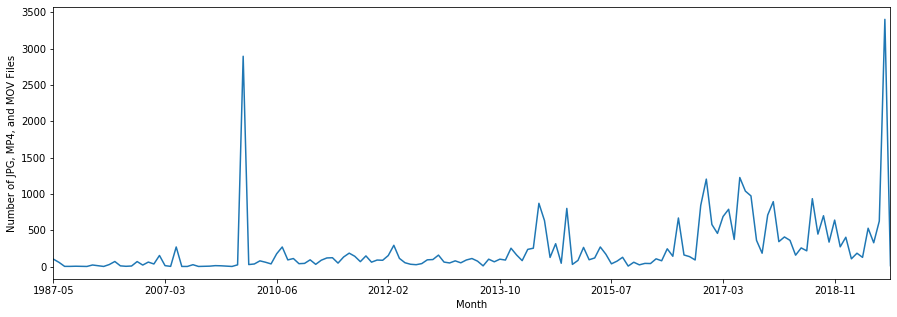

In [4]:
Photo_DF[Photo_DF.extension.isin(['jpg','mp4','mov'])].mtime.apply(lambda x:x.strftime('%Y-%m')).value_counts().sort_index().plot(figsize=(15,5))
plt.xlabel('Month')
plt.ylabel('Number of JPG, MP4, and MOV Files')
plt.show()

In [18]:

Image(filename=Photo_DF[Photo_DF.mtime==Photo_DF.mtime.min()].path)
Image(filename=Photo_DF[Photo_DF.mtime==Photo_DF.mtime.max()].path)
Photo_DF[Photo_DF.mtime==Photo_DF.mtime.min()].path.iloc[0]
Photo_DF[Photo_DF.mtime==Photo_DF.mtime.max()].path.iloc[0]
get_date_taken(Photo_DF[Photo_DF.mtime==Photo_DF.mtime.max()].path.iloc[0])

'2009:10:19 11:49:34'